In [53]:
import miniai.datasets as ds
import miniai.conv as cv
import miniai.training as tr

import torch
import matplotlib as mpl

mpl.rcParams["image.cmap"] = "gray"

# Autoencoders

## Data

In [2]:
from datasets import load_dataset, VerificationMode

name = "fashion_mnist"
dataset_dict = load_dataset(name, verification_mode=VerificationMode.NO_CHECKS)

In [3]:
import torchvision.transforms.functional as TF


# Convert each image to a tensor
@ds.inplace
def transformi(items):
    items["image"] = [TF.to_tensor(o) for o in items["image"]]

In [4]:
batch_size = 256
tdataset_dict = dataset_dict.with_transform(transformi)

<Axes: >

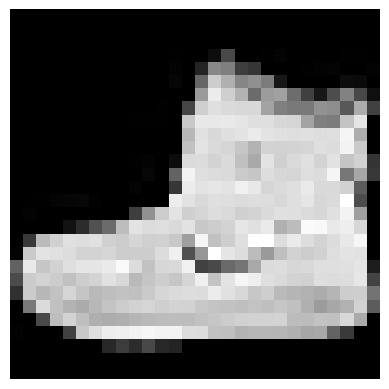

In [5]:
train_ds = tdataset_dict["train"]

ds.show_image(train_ds[0]["image"])

In [6]:
from torch.utils.data import DataLoader

collate_dict = ds.collate_dict(train_ds)


# Collate from dict to duple and shove on our device
def collate_to_dev(items):
    return cv.to_device(collate_dict(items))


# Take a DatasetDict and give back a dict of DataLoaders
def data_loaders(dsd, batch_size, **kwargs):
    return {key: DataLoader(val, batch_size, **kwargs) for key, val in dsd.items()}


dls = data_loaders(tdataset_dict, batch_size, collate_fn=collate_to_dev)

In [7]:
train_ds.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [19]:
# Pull  the labels from the first 16 items
from operator import itemgetter

xb, yb = next(iter(dls["train"]))

lbl_getter = itemgetter(*yb[:16])
titles = lbl_getter(train_ds.features["label"].names)

titles

('Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top',
 'Pullover',
 'Sneaker',
 'Pullover',
 'Sandal',
 'Sandal',
 'T - shirt / top',
 'Ankle boot',
 'Sandal',
 'Sandal',
 'Sneaker',
 'Ankle boot')

4 4


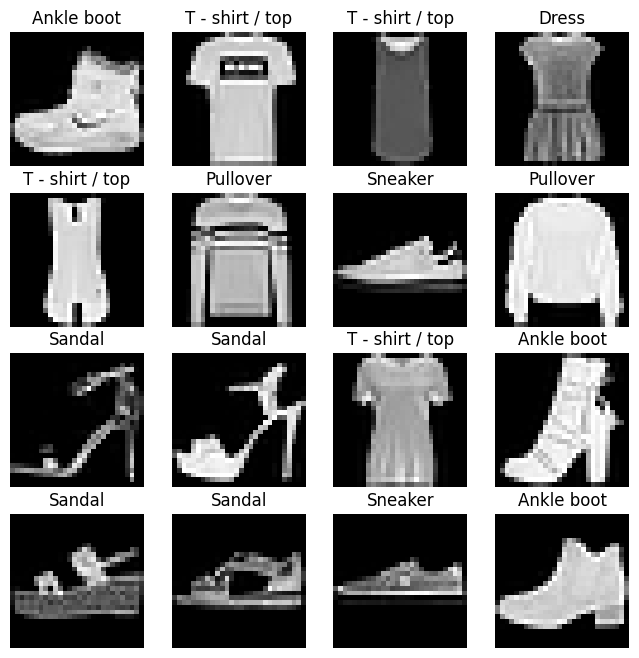

In [18]:
# Show the images and their labels
ds.show_images(xb[:16], imsize=2, titles=titles)

## Classifier

Lets make a classifier.

In [30]:
from torch import nn

lr = 0.4

cnn = nn.Sequential(
    cv.conv(1, 4),  # 14x14
    cv.conv(4, 8),  # 7x7
    cv.conv(8, 16),  # 4x4
    cv.conv(16, 16),  # 2x2
    cv.conv(16, 10, act=False),  # 1x1
    nn.Flatten(),  # Remove extra dims
).to(cv.def_device)

In [31]:
from torch import optim
import torch.nn.functional as F

opt = optim.SGD(cnn.parameters(), lr=lr)
loss, acc = tr.fit(5, cnn, F.cross_entropy, opt, dls["train"], dls["test"])

epoch: 0, loss: 0.6919707830111186, acc: 0.7471666666666666
epoch: 1, loss: 0.5262367455641429, acc: 0.8112666666666667
epoch: 2, loss: 0.4353276350180308, acc: 0.83955
epoch: 3, loss: 0.39981862274010976, acc: 0.8518000000635783
epoch: 4, loss: 0.38506869491736095, acc: 0.859


This was very slow. Why? Consider one item.

In [33]:
dataset_dict["train"][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

Each item is its own image, so our dataloader is spending all its time decoding these .png files. This leaves us with a heavily CPU bound operation. We are also only decoding one image at a time.

We can tell our dataloaders to load data in parallel using `num_workers=X`. Unfortunately we can have these multiple processess all putting things onto the GPU. We would have to rewrite `fit` and collation to do something about this.

The other problem is that its not very good/accurate so we need to improve that too.

## Autoencoder

Lets make an autoencoder. What is that. Consider our convolutions that are reducing the size of our output grid. Its essentially a form of compression. What if we wanted the get it back to its original size?

One approach would be nearest neighbour upsampling - copy the same pixel into multiple pixels in the increased size output. For example:

```
ab -> aabb
cd    aabb
      ccdd
      ccdd
```

We could then apply a stride 1 convolution to that.

In [41]:
# Create a "deconvolution" layer that upsamples and the does a stride 1 conv with an optional activation fn.
def deconv(in_channels, out_channels, kernel_size=3, act=True):
    layers = [
        nn.UpsamplingNearest2d(scale_factor=2),
        nn.Conv2d(in_channels, out_channels, stride=1, kernel_size=kernel_size, padding=kernel_size // 2),
    ]

    if act:
        layers.append(nn.ReLU())

    return nn.Sequential(*layers)

In [48]:
# Slap this all together and we have an autoencoder that "compresses" down to 4x4 and upsamples
# back up to 28x28

autoencoder = nn.Sequential(  # 28x28
    nn.ZeroPad2d(2),  # 32x32, we 0 pad as we want to go down to 4x4 and 32 divedes
    cv.conv(1, 2),  # 16x16
    cv.conv(2, 4),  # 8x8
    cv.conv(4, 8),  # 4x4
    deconv(8, 4),  # 8x8
    deconv(4, 2),  # 16x16
    deconv(2, 1, act=False),  # 32x32
    nn.ZeroPad2d(-2),  # 28x28
    nn.Sigmoid(),  # Force everything between 0 and one
).to(cv.def_device)

In [54]:
# Use MSE loss to compare input and output pixels, so we can train the autoencoder to reproduce the original input
# This means our loss function needs do compare input and output rather than the actual targets
# We will just rewrite our fit function to do this for now


def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, _ in train_dl:
            loss = loss_func(model(xb), xb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            tot_loss, count = 0.0, 0
            for xb, _ in valid_dl:
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred, xb).item() * n
        print(epoch, f"{tot_loss/count:.3f}")


opt = optim.AdamW(autoencoder.parameters(), lr=0.01)
fit(5, autoencoder, F.mse_loss, opt, dls["train"], dls["test"])

0 0.022
1 0.019
2 0.018
3 0.018
4 0.018


16 16


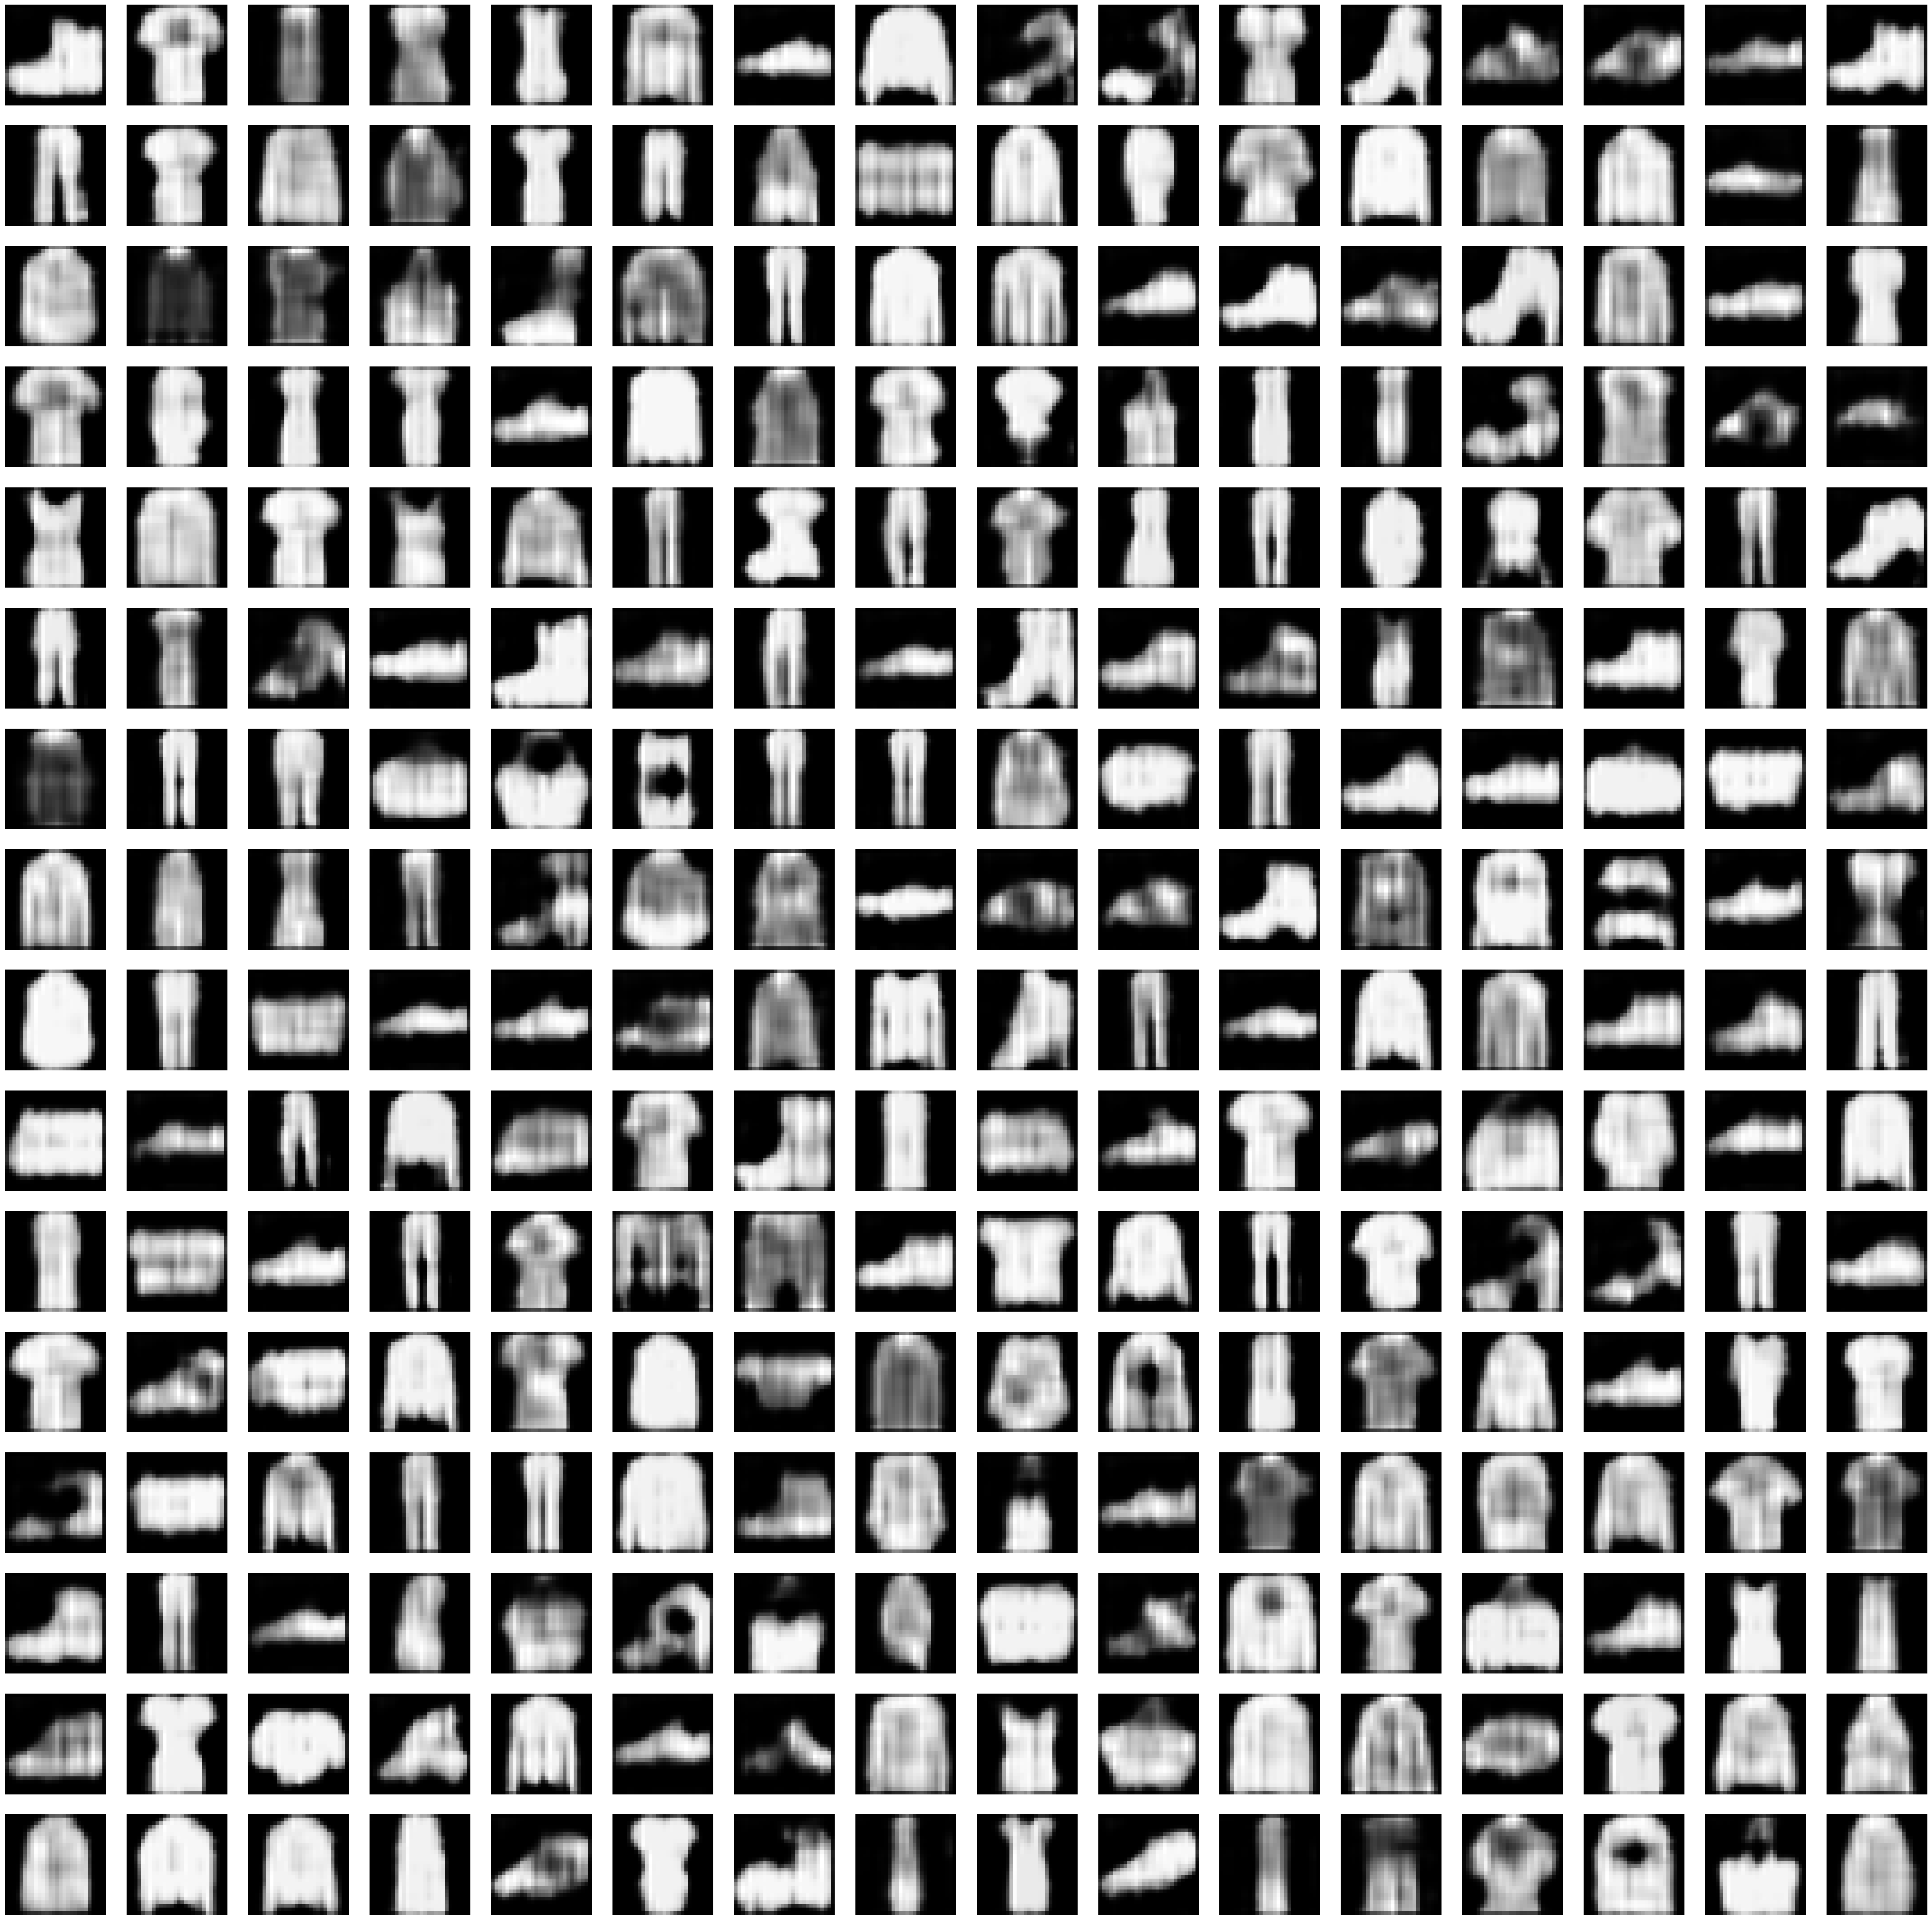

In [57]:
# Well the accuracy is getting better but how does it do?
out = autoencoder(xb)
ds.show_images(out)

Not that great. Our autoencoder does not get very close to recreating the originals. We need to do a better job of training our autoencoder. WE could try and do this manually but its a bit diffly and will be very time consuming. Lets make a learner framework thats a bit more than just our fit function and helps us out.